# Support Vector Regression

Magdalena Claessen (579362)

Die Support Vector Machine (SVM) gehört zum überwachten Lernen des maschinellen Lernens. Das Ziel des Algorithmus ist, Daten zu klassifizieren, indem es eine Hyperebene mit maximalen Abstand zwischen den Klassen in einem n-dimensionalen Raum findet. Demnach eignet sich die Support Vector Machine für Klassifizierungsprobleme. Aufgrund dessen, dass ein Regressionsproblem in Form einer Zeitreihe vorliegt, kann die SVM nicht verwendet werden. Stattdessen eignet sich die Support Vector Regression (SVR). Die SVR sucht eine Funktion, die die Datenpunkte innerhalb eines vogegebenen Toleranzbereichs (ε) möglichst gut approximiert. Datenpunkte, die innerhalb des ε-Toleranzbereichs liegen, werden nicht bestraft, während Punkte außerhalb eine Strafe basierend auf der Entfernung zur vorhergesagten Funktion erhalten. (López et al. 2022, S. 369)

Für die Auswahl des maschinellen Lernverfahrens wird das Paper "Support Vector Regression (SVR) Model for Seasonal Time Series Data" von H. Muthiah, U. Sa'adah und A. Efendi herangezogen. In diesem Paper wird die Zeitreihe der Stromlasten in der Region Ost-Java (Indonesien) mit insgesamt 182 Datenpunkten mit der SVR trainiert und vorhergesagt. Dabei wird die Performance der verschiedenen Kernels linear und rbf im Vergleich getestet. Das Ergebnis der Vorhersage nach Aufbereitung mit SARIMA (Seasonal Autoregressive Integrated Moving Average), dem Training und der Modellevaluation mit dem Root Mean Squared Error (RMSE) ist, dass der lineare Kernel bessere Vorhersagen für diese Zeitreihe trifft. (Muthiah et al. 2021, S. 3195 ff.)

In diesem Notebook werden zunächst die bereits im Notebook "6_preprocessing" beschriebenden Schritte zur Datenvorverarbeitung durchgeführt. Anschließend folgt die Implementierung des Modells mit Standardwerten und ein Vergleich zur LinearSVR. Die Lag Features werden in das Modell integriert und im Anschluss werden die Hyperparameter des Modells angepasst. Schließlich kann das finale Modell implementiert, triniert und getestet werden. Für die Implementierung der Support Vector Regression für den Rossmann Store Datensatz wird die Python-Bibliothek SciKit-learn verwendet. Diese Bibliothek ist speziell für das maschinelle Lernen konzipiert und stellt die SVR zur Verfügung.  

In [1]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Daten einlesen

In [2]:
data_cleaned = "../data/cleaned_train_marie.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

## Features

In [3]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday']
# numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365'] #Verwendet bei Standardwerten

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

# Split

In [4]:
data = data.sort_values('Date')

data = data[data ['Open']!=0]
data = data[data ['Sales']>0]

# Stichprobengröße von 20%
# sample_fraction = 0.2 
# sample_size = int(len(data) * sample_fraction)
# data_sample = data.iloc[:sample_size]

# Zielvariable und Features definieren
X = data.drop(['Sales'], axis=1)
y = data['Sales']

test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

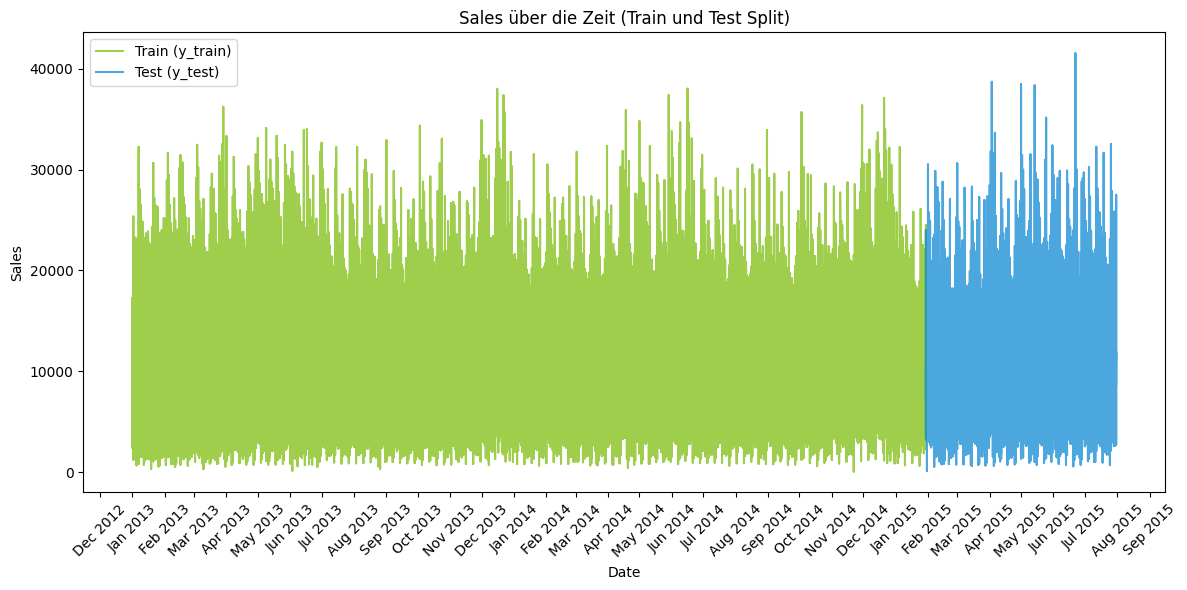

In [5]:
X_train.loc[:, 'Date'] = pd.to_datetime(X_train['Date'], errors='coerce')
X_test.loc[:, 'Date'] = pd.to_datetime(X_test['Date'], errors='coerce')

plt.figure(figsize=(12, 6))
plt.plot(X_train['Date'], y_train, label='Train (y_train)', color='#76B900', alpha=0.7)
plt.plot(X_test['Date'], y_test, label='Test (y_test)', color='#0082D1', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales über die Zeit (Train und Test Split)')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Metrik

In [6]:
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Kreuzvalidierung (TimeSeries)

In [7]:
tscv = TimeSeriesSplit(n_splits=5)

# Pre-processing

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), 
        ('enc', 'passthrough', already_encoded_features),  
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode) 
    ])

# Support Vector Regression

Um ein effektives Modell für die Support Vector Regression zu entwickeln, wird eine Pipeline implementiert, die den Preprocessor und das Modell umfasst. Die Pipeline automatisiert den Prozess der SVR und vereinfacht den Umgang mit Daten und Modell. (SciKit-Learn, n.d.-a) Die verwendete Support Vector Regression von SciKit-Learn bietet verschiedene Parameter zur Anpassung des Modells:
- Kernel: Dieser Parameter gibt den verwendeten Kerneltyp an. Mögliche Werte sind linear, rbf, poly, sigmoid, precomuted (default: rbf)
- C: Der Regulierungsparameter, der je nach Größe die Daten bestraft. Bei einem niedrigen Wert werden mehr Fehler erlaubt, wobei bei einem hohen C-Wert weniger Fehler erlaubt sind. (default: 1.0)
- Epsilon: Gibt die Toleranz gegenüber Fehlern an. Innerhalb des Toleranzbereichs werden die Punkte nicht bestraft. (default: 0.1)
- Gamma: dieser Parameter wird angegeben, wenn der Kernel rbf, poly oder sigmoid ist. Mögliche Werte sind scale oder auto. (default: scale)

(SciKit-Learn, n.d.-b)

Zunächst wird die SVR mit den dafault-Werten auf den Trainingsdaten trainiert. Die hierfür verwendeten Features sind:
- numerische Features: 'year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365'
- encoded Features: 'Promo', 'promo2'
- kategorische Features: 'DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store'

Der erste Durchlauf mit den default-Werten dient dazu, die Grundleistung des Modells ohne Optimierung zu überprüfen. Die Ergebnisse der fünfachen Time Series Kreuzvalidierung zeigen folgenden RMSPE Werte:
- Fold 1: 0.5392254908405987
- Fold 2: 0.4809429942883717
- Fold 3: 0.4518889103767877
- Fold 4: 0.45680753303355526
- Fold 5: -

Nach über 10 Stunden wurde der Durchlauf gestoppt und der durchschnittlicher RMSPE wurde manuell über die vier berechneten Folds ermittelt. Der durchschnittliche RMSPE ist 0.4822162321348283.

Aufgrund dieser schlechten RMSPE-Werte wird die LinearSVR als Vergleich herangezogen. Der Unterschied zur SVR liegt in der Verwendung eines linearen Kernels, der es ermöglicht, das Modell effizienter auf größere Datenmengen zu trainieren. Ein Hyperparameter-Tuning, das mit 20% des Datensatzes durchgeführt wurde, zeigt, dass der lineare Kernel ebenfalls die besseren Ergebnisse liefert. Die lineare SVR von SciKit-Learn bietet folgende Parameter zur Anpassung des Modells:
- Epsilon: Gibt die Toleranz gegenüber Fehlern an. Innerhalb des Toleranzbereichs werden die Punkte nicht bestraft. (default: 0.0)
- C: Der Regulierungsparameter, der je nach Größe die Daten bestraft. Ein niedriger C-Wert erlaubt mehr Fehler und führt zu einer stärkeren Regularisierung, was ein einfacheres Modell ergibt. Ein hoher C-Wert bestraft Fehler stärker und lässt weniger Fehler zu. Das Modell wir komplexer. (default: 1.0)
- loss: Die Verlustfunktion, die für das Modell verwendet wird. (default: epsilon_insensitive)

(SciKit-Learn, n.d.-c)

Die RMSPE-Werte der fünfachen Time Serie Kreuzvalidierung bei oben genannten Features sind folgende:
- Fold 1: 0.45677323476966736
- Fold 2: 0.39130488386280415
- Fold 3: 0.394032395948371
- Fold 4: 0.3747369458031788
- Fold 5: 0.5392642148781003

Zur Vergleichbarkeit mit der SVR wurde hier ebenfalls der durchschnittliche RMSPE manuell nach vier Folds berechnet. Der durchschnittlicher RMSPE nach vier Folds beträgt 0.4042118650960053, während der nach fünf Folds 0.4312223350524243 ist. Der RMSPE des Testdatensatze beträgt 0.3874564763858707. Diese Ergebnisse verdeutlichen, dass der Fehler bei der linearen SVR geringer ist und aus diesem Grund wird der lineare Ansatz weiter verfolgt. Ebenfalls ist zu erkennen, dass der RMSPE des Testdatensatzes geringer als der der Trainingsdatensatzes ist. Demnach kann das Modell gut mit neuen Daten umgehen.

## Support Vector Regression (SVR)

In [85]:
svr = SVR()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', svr)])

In [ ]:
rsmpe_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")

    # Train- und Testdaten für diesen Fold
    X_train_fold = X_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_train_fold = y_train.iloc[train_index]
    y_test_fold = y_train.iloc[test_index]

    pipeline.fit(X_train_fold, y_train_fold)

    y_pred_fold = pipeline.predict(X_test_fold)

    rmspe_score = rmspe(y_test_fold, y_pred_fold)
    rsmpe_scores.append(rmspe_score)

    print(f"RMSPE für Fold {fold + 1}: {rmspe_score}")

Fold 1
RMSPE für Fold 1: 0.5392254908405987
Fold 2
RMSPE für Fold 2: 0.4809429942883717
Fold 3
RMSPE für Fold 3: 0.4518889103767877
Fold 4
RMSPE für Fold 4: 0.45680753303355526
Fold 5


## SVR mit GridSearchCV bei 20% der Datenmenge

In [32]:
svr = SVR()

In [33]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', svr)])

In [34]:
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__epsilon': [0.01, 0.1, 0.5, 1],
    'model__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=rmspe_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'week_of_year',
                                                                          'fourier_sin_365',
                                                                          'fourier_cos_365']),
                                                                        ('enc',
                                                                         'passthrough',
                                                                         ['Promo',
                                                                          'promo2']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['DayOfWeek',
                                                                          'StoreType',
                                                                          'StateHoliday',
                                                                          'Assortment',
                                                                          'Store'])])),
                                       ('model', SVR())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__epsilon': [0.01, 0.1, 0.5, 1],
                         'model__kernel': ['linear', 'rbf']},
             scoring=make_scorer(rmspe, greater_is_better=False, response_method='predict'))

In [35]:
print("Beste Parameter: ", grid_search.best_params_)

Beste Parameter:  {'model__C': 100, 'model__epsilon': 1, 'model__kernel': 'linear'}


In [36]:
y_pred = grid_search.predict(X_test)

rmspe_score = rmspe(y_test, y_pred)
print(f'RMSPE auf Testdaten: {rmspe_score}')

RMSPE auf Testdaten: 0.4829542601858057


## Linear Support Vector Regression (LinearSVR)

In [109]:
linear_svr = LinearSVR()

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_svr)])

In [110]:
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model', LinearSVR())])

In [111]:
# RMSPE der einzelnen Folds
cv_scores = cross_val_score(linear_pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)
cv_scores

array([-0.45625439, -0.39005451, -0.3946015 , -0.37458995, -0.5392183 ])

In [112]:
# Durschnittlicher RMSPE über alle Folds
mean_rmspe = np.mean(cv_scores)
mean_rmspe

np.float64(-0.4309437297292072)

In [113]:
# RMSPE des Testdatensatzes
y_pred = linear_pipeline.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

np.float64(0.3874564763858707)

## Vergleich SVR und LinearSVR

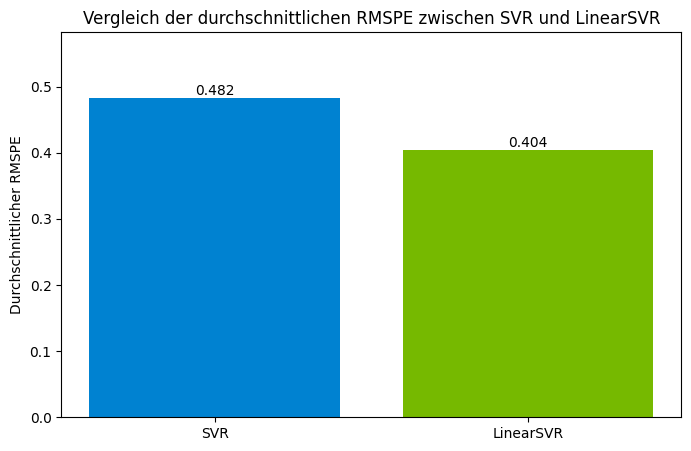

In [20]:
rmspe_scores_svr = [0.5392254908405987, 0.4809429942883717, 0.4518889103767877, 0.45680753303355526]
rmspe_scores_linearsvr = [0.45625439, 0.39005451, 0.3946015 , 0.37458995]

rmspe_svr = np.mean(rmspe_scores_svr)
rmspe_linearsvr = np.mean(rmspe_scores_linearsvr)

labels = ['SVR', 'LinearSVR']
means = [rmspe_svr, rmspe_linearsvr]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, color=['#0082D1', '#76B900'])

for i, value in enumerate(means):
    plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')

plt.ylabel('Durchschnittlicher RMSPE')
plt.title('Vergleich der durchschnittlichen RMSPE zwischen SVR und LinearSVR')
plt.ylim(0, max(means) + 0.1)
plt.show()

# Lag Features

Für die weitere Verbesserung des Modells werden die Lag Features 1 und 7 hinzugefügt. Der durchschnittliche RMSPE hat sich jedoch durch die Implementierung der Lag Features verschlechtert, sodass diese nicht als Features aufgenommen werden. 

In [ ]:
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday', 'lag_1', 'lag_7']
already_encoded_features = ['Promo', 'promo2']
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

In [ ]:
linear_svr = LinearSVR(random_state=42)

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_svr)])

In [ ]:
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)

    predictions = []
    last_known_sales = list(y_fold_train[-7:])
    
    for index, row in X_fold_val.iterrows():
        try:
            row["lag_1"] = last_known_sales[-1] 
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
        
        row = row.to_frame().T
        
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0]) 
        
        last_known_sales.append(pred[0])
    
    return predictions

In [ ]:
rmspe_scores = [] 

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    X_fold_train_preprocessed = linear_pipeline.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = linear_pipeline.named_steps['preprocessor'].transform(X_fold_test)
    
    y_pred = iterative_forecast(linear_pipeline, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    y_pred_fold = pd.Series(y_pred, index=y_fold_test.index)

    rmspe_score = rmspe(y_fold_test, y_pred_fold)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1
RMSPE for Fold 1: 1.8829888867276858
Fold 2
RMSPE for Fold 2: 1.547772099271759
Fold 3
RMSPE for Fold 3: 1.5030710373521154
Fold 4
RMSPE for Fold 4: 1.3939387321340133
Fold 5
RMSPE for Fold 5: 1.3692937252692006
Durchschnittliche RMSPE über alle Folds: 1.5394128961509548


# Hyperparameter Optimierung

Bevor das Hyperparamter Tuning durchgeführt wird, wurde sich in der Gruppe auf die folgenden Features geeinigt, sodass diese für weitere Analysen verwendet werden. 
- numerische Features: 'year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365', 'days_since_last_holiday',	'days_until_next_holiday'
- encoded Features: 'Promo', 'promo2'
- kategorische Features: 'DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store'

Für das Hyperparameter Tuning werden die Methoden RandomizedSearchCV und GridSearchCV gegeneinander getestet, sodass die besten Parameter gefunden werden können. RandomizedSearchCV ist eine kreuzvalidierte Suche, die nicht alle Parameterwerte ausprobiert, sondern mit einer festen Anzahl arbeitet. Die Anzahl kann durch n_iter angegeben und verändert werden. (SciKit-Learn, n.d.-d) Im Gegensatz dazu ist GridSearchCV eine kreuzvalidierte Rastersuche, die alle Parameterwerte ausprobiert.(SciKit-Learn, n.d.-e) Beide Verfahren wurden auf das Modell mit den oben gegnannten Features angewendet und im Anschluss jeweils eine Vorhersage auf den Testdaten gestartet. Die Ergbnisse sind:
- RandomizedSearchCV
    - Beste Parameter: {'model__loss': 'epsilon_insensitive', 'model__epsilon': 0.21544346900318845, 'model__C': 46.41588833612773}
    - RMSPE auf den Testdaten: 0.2773890240861983
- GridSearchCV
    - Beste Parameter: {'model__C': 10, 'model__epsilon': 0.1, 'model__loss': 'epsilon_insensitive'}
    - RMSPE auf den Testdaten: 0.28647300992303587

Demnach sind die Ergebnisse der RandomizedSearchCV besser als die der GridSearchCV, da der RMSPE der Testdaten geringer ist. Die Parameter der RandomizedSearchCV werden für das Modell verwendet.

(Für die Angabe der param_distribustions wurde bei beiden Modellen OpenAI verwendet (OpenAI, 2024).)


## RandomizedSearchCV

In [17]:
linear_svr_random = LinearSVR(random_state=42)

linear_pipeline_random = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_svr_random)])

In [18]:
param_distributions = {
    'model__C': np.logspace(-3, 3, 10),  # Logarithmische Verteilung der Werte für C
    'model__epsilon': np.logspace(-4, 1, 10),
    'model__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}
random_search = RandomizedSearchCV(linear_pipeline_random, param_distributions, n_iter=50, cv=tscv, scoring=rmspe_scorer, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

y_pred_train = random_search.predict(X_train)
y_pred_test = random_search.predict(X_test)

rmspe_train_random = rmspe(y_train, y_pred_train)
rmspe_test_random = rmspe(y_test, y_pred_test)

print("Beste Parameter:", random_search.best_params_)
print(f"Train RMSPE: {rmspe_train_random:.4f}")
print(f"Test RMSPE: {rmspe_test_random:.4f}")

Beste Parameter: {'model__loss': 'epsilon_insensitive', 'model__epsilon': np.float64(0.21544346900318845), 'model__C': np.float64(46.41588833612773)}
Train RMSPE: 0.3126
Test RMSPE: 0.2774


## GridSearchCV

In [20]:
linear_svr_grid = LinearSVR(random_state=42)

linear_pipeline_grid = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_svr_grid)])

In [136]:
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__epsilon': [0.001, 0.01, 0.1, 1],
    'model__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

grid_search = GridSearchCV(linear_pipeline_grid, param_grid, cv=tscv, scoring=rmspe_scorer)
grid_search.fit(X_train, y_train)

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

rmspe_train_grid = rmspe(y_train, y_pred_train)
rmspe_test_grid = rmspe(y_test, y_pred_test)

print("Beste Parameter:", grid_search.best_params_)
print(f"Train RMSPE: {rmspe_train_grid:.4f}")
print(f"Test RMSPE: {rmspe_test_grid:.4f}")

Beste Parameter: {'model__C': 10, 'model__epsilon': 0.1, 'model__loss': 'epsilon_insensitive'}
Train RMSPE: 0.3213
Test RMSPE: 0.2865


## Vergleich RandomizedSearchCV und GridSearchCV

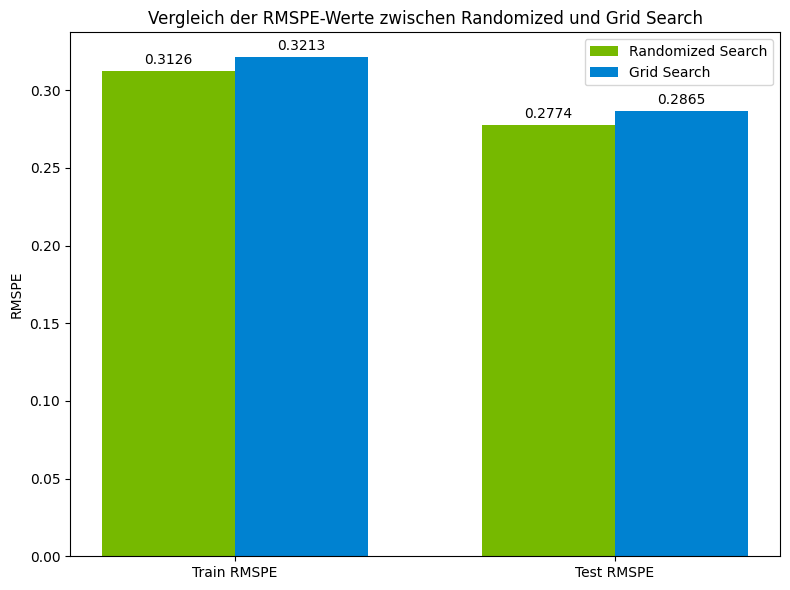

In [152]:
rmspe_random_train = rmspe_train_random
rmspe_random_test = rmspe_test_random
rmspe_grid_train = rmspe_train_grid
rmspe_grid_test = rmspe_test_grid

labels = ['Train RMSPE', 'Test RMSPE']
randomized_search = [rmspe_random_train, rmspe_random_test]
grid_search = [rmspe_grid_train, rmspe_grid_test]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, randomized_search, width, label='Randomized Search', color='#76B900')
rects2 = ax.bar(x + width/2, grid_search, width, label='Grid Search', color='#0082D1')

ax.set_ylabel('RMSPE')
ax.set_title('Vergleich der RMSPE-Werte zwischen Randomized und Grid Search')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

# Finales Modell trainieren

## Beste Hyperparameter

In [74]:
best_params = {
    'epsilon': 0.21544346900318845,
    'C': 46.41588833612773,
    'loss': 'epsilon_insensitive'
}

In [75]:
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday']
already_encoded_features = ['Promo', 'promo2']
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), 
        ('enc', 'passthrough', already_encoded_features),  
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode) 
    ])

## Initalisierung der Pipeline

In [76]:
linear_svr = LinearSVR(**best_params, random_state=42)

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_svr)])

## Training

In [77]:
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model',
                 LinearSVR(C=46.41588833612773, epsilon=0.21544346900318845,
                           random_state=42))])

## Kreuzvalidierung

In [78]:
cv_scores = cross_val_score(linear_pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)
mean_rmspe = np.mean(cv_scores)
mean_rmspe

np.float64(-0.31919044322710344)

## Test

In [79]:
y_pred = linear_pipeline.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

np.float64(0.2773890240861983)

## Überprüfung Overfitting

Ein Vergleich des Trainings und Test RMSPE zeigt, dass das Modell gut generalisiert ist und kein Overfitting vorliegt. Der Test RMSPE ist geringer als der Trainings RMSPE, sodass die Aussage getroffen werden kann, dass das Modell unbekannte Daten besser vorhersagt als die trainierten. Die im Diagramm dargestellte Learning Curve verdeutlicht den Verlauf des RMSPE für den Trainingsdatensatz als auch der Kreuzvalidierung in Abhängigkeit der Anazhl der Trainingsbeispiele. Die grüne Linie zeigt hierbei den RMSPE auf den Trainingsdaten an und ist nahe zu konstant. Das Modell weißt einen geringen Fehler auf. Die blaue Linie hingegen stellt den RMSPE auf den Kreuzvalidierungsdaten dar. Dieser schwankt stark und ist bei einer geringen Menge an Trainingsbeispielen sehr hoch. Mit zunehmender Anzahl an Trainingsbeispielen ist eine Seknung des RMSPE bis zur Stabilisation zu beobachten. Dementsprechend generalisiert das Modell mit einer größeren Anzahl an Trainingsdaten besser. Der schattierte Bereich hebt die Varianz des Kreuzvalideriungs-RMSPE hervor, wobei auch hier die Varianz bei einer geringen Trainingsdatenanzahl höher ist also bei einer größeren Anzahl.  

In [50]:
y_train_pred = linear_pipeline.predict(X_train)
y_test_pred = linear_pipeline.predict(X_test)

train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

print(f'Training RMSPE: {train_rmspe}')
print(f'Test RMSPE: {test_rmspe}')

Training RMSPE: 0.3126305515318233
Test RMSPE: 0.2773890240861983


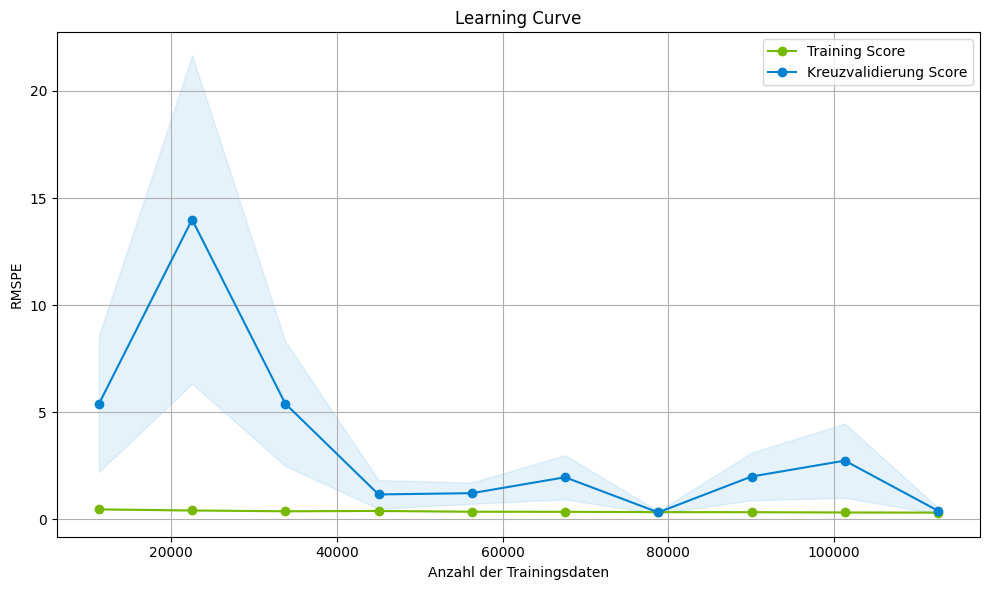

In [56]:
train_sizes, train_scores, test_scores = learning_curve(linear_pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#76B900")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#0082D1")
plt.plot(train_sizes, train_scores_mean, 'o-', color="#76B900", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="#0082D1", label="Kreuzvalidierung Score")

plt.xlabel("Anzahl der Trainingsdaten")
plt.ylabel("RMSPE")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualisierungen

### Vergleich der tatsächlichen und vorhergesagten Sales für die Stores 50, 75, 175

Das Diagramm zeigt die tatsächlichen Sales im Vergleich zu den vorhergesagten Sales im Zeitraum des Testdatensatzes für die drei zufällig ausgewählten Stores 50, 75 und 175. Die blaue Linie stellt hierbei die tatsächlichen Sales und die orangene gestrichelte Line die vorhergesagten Sales dar. Der Zeitraum beinhaltet die Monate von Januar 2015 bis August 2015. Bei dem Store 50 ist der Trend der tatsächlichen Werte ebenfalls bei den vorhergesagten Werten zu erkennen, allerdings liegen ausgeprägte Ausschlägen vor. Bei dem Store 75 liegt ein ähnliches Muster bei den Vorhersagen wie bei Store 50 vor. Hingegen bei Store 175 liegen die vorhergesagten Werte näher an den tatsächlichen Werten. Trotzdem liegen weiterhin hohe Ausschläge vor, aber es wird im Verlauf nicht so stark überschätzt wie bei den anderen beiden Stores. 

In [68]:
X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce') 

C:\Users\schmu\AppData\Local\Temp\ipykernel_10972\1181527785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')


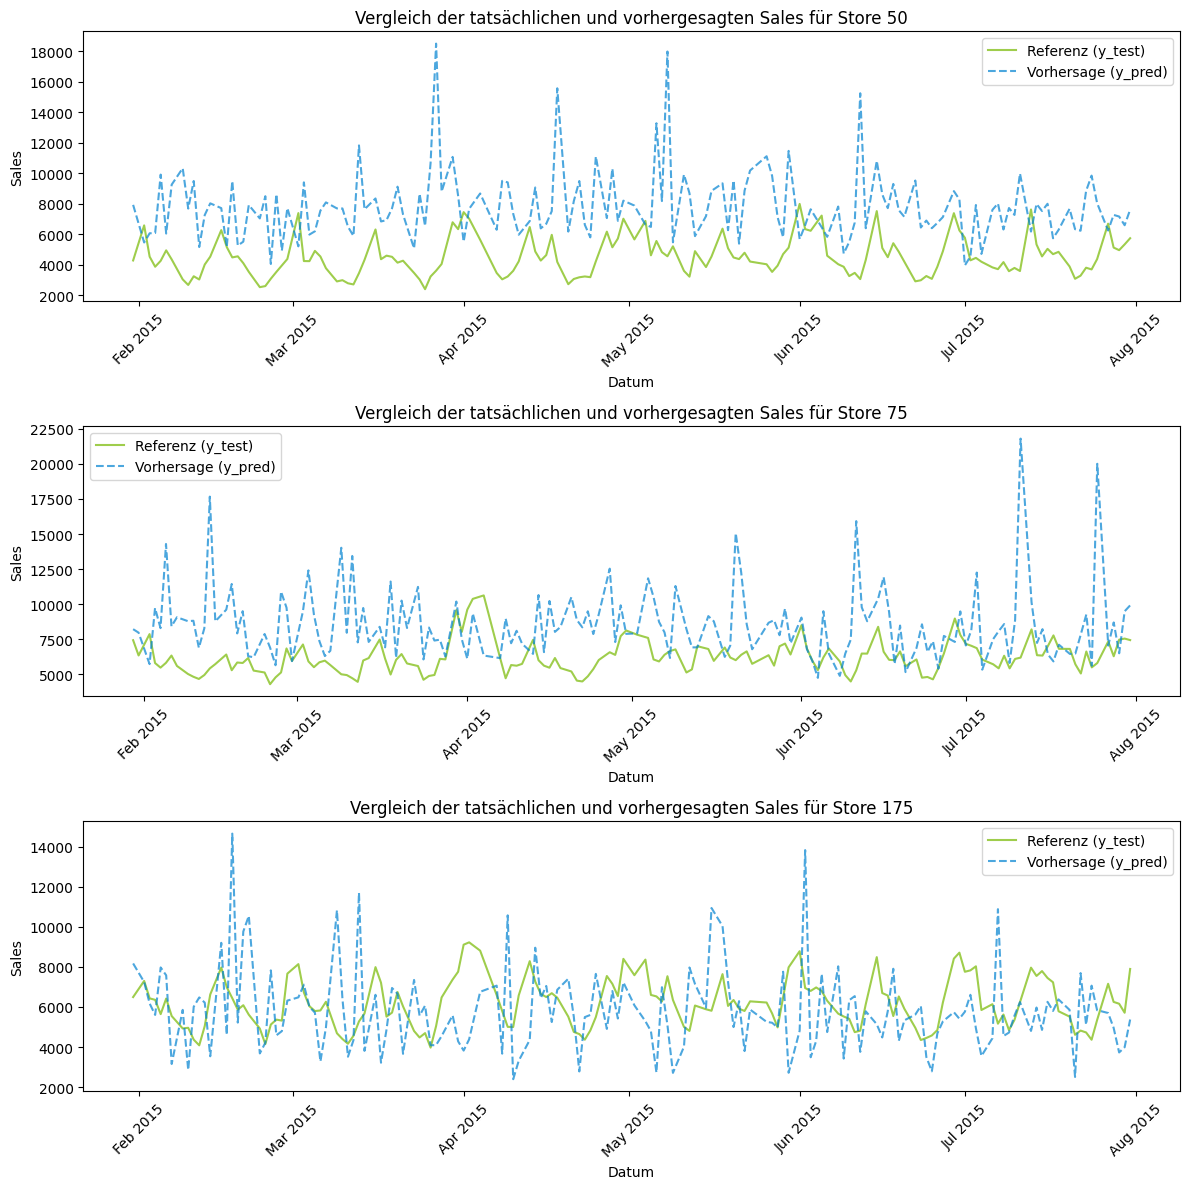

In [69]:
store_list = [50, 75, 175] 

num_stores = len(store_list)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 4 * num_stores))

if num_stores == 1:
    axes = [axes] 

for i, store in enumerate(store_list):
    store_test_data = X_test[X_test['Store'] == store]
    store_y_test = y_test[store_test_data.index]
    
    store_indices = store_test_data.index
    store_y_pred = y_pred[store_indices - X_test.index.min()]
    
    store_test_data = store_test_data.sort_values('Date')
    store_y_test = store_y_test[store_test_data.index]
    store_y_pred = store_y_pred[np.argsort(store_test_data['Date'].values)]
 
    axes[i].plot(store_test_data['Date'], store_y_test, label='Referenz (y_test)', linestyle='-', marker='', alpha=0.7, color='#76B900')
    axes[i].plot(store_test_data['Date'], store_y_pred, label='Vorhersage (y_pred)', linestyle='--', marker='', alpha=0.7, color='#0082D1')
    
    axes[i].xaxis.set_major_locator(mdates.MonthLocator()) 
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
    
    axes[i].set_xlabel('Datum')
    axes[i].set_ylabel('Sales')
    axes[i].set_title(f'Vergleich der tatsächlichen und vorhergesagten Sales für Store {store}')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

### Kumulierte Darstellung der tatsächlichen und vorhergesagten Sales

Das Diagramm zeigt die kumulierten Verkaufszahlen für den Store 1 im Vergleich für den Zeitraum des Testdatensatzes. Die Linien verlaufen nah beieinander, dennoch treten Abweichungen auf. Die grüne Linie stellt die kumulierten tatsächlichen Sales dar, während die blaue Linie die kumulierten vorhergesagten Sales visualisiert. Zu Beginn des Zeitraums werden die Sales von dem Modell unterschätzt, denn die blaue Linie liegt unterhalb der grünen Linie. Im Vergleich dazu wird am Ende des Zeitraums die Sales vom Modell überschätzt.   

In [94]:
store_id = 1
store_data = data[data['Store'] == store_id]

X_store = store_data.drop('Sales', axis=1) 
y_store = store_data['Sales'] 

y_store_pred = linear_pipeline.predict(X_store)

results = pd.DataFrame({
    'Date': store_data['Date'],
    'Actual Sales': y_store,
    'Predicted Sales': y_store_pred
})
results.sort_values('Date', inplace=True)

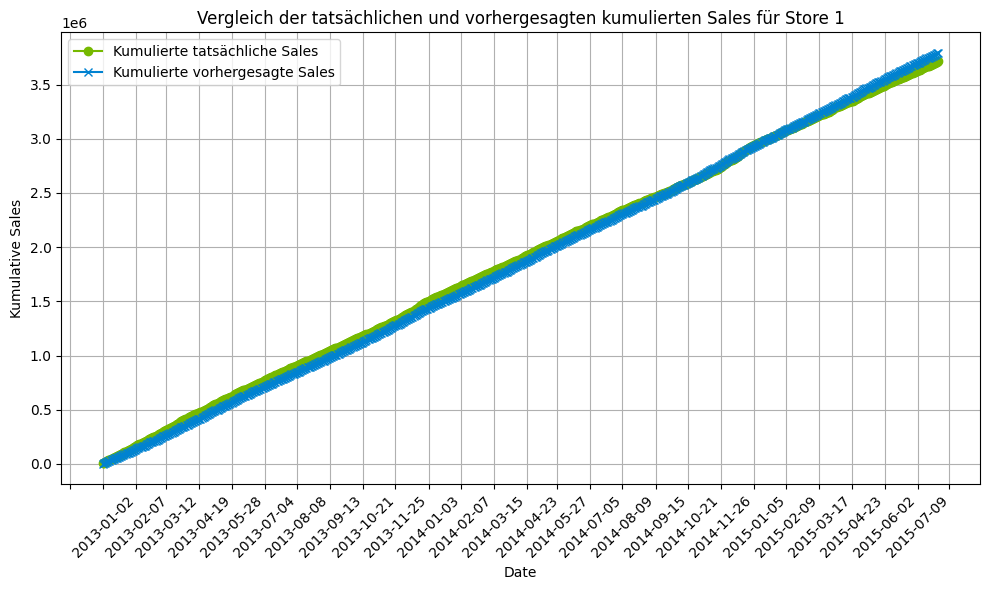

In [95]:
results['Cumulative Actual Sales'] = results['Actual Sales'].cumsum()
results['Cumulative Predicted Sales'] = results['Predicted Sales'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Cumulative Actual Sales'], label='Kumulierte tatsächliche Sales', marker='o', color='#76B900')
plt.plot(results['Date'], results['Cumulative Predicted Sales'], label='Kumulierte vorhergesagte Sales', marker='x', color='#0082D1')

plt.xlabel('Date')
plt.ylabel('Kumulative Sales')
plt.title(f'Vergleich der tatsächlichen und vorhergesagten kumulierten Sales für Store {store_id}')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Streudiagramm der tatsächlichen und vorhergesagten Sales für Store 1

Das Streudiagramm zeigt die tatsächlichen Sales gegen die vorhergesagten Sales für den Store 1 im Zeitraum des Testdatensatzes. Jeder Punkt repräsentiert einen Tag. Die x-Achse visualisiert die tatsächlichen Sales, während die y-Achse die vorhergesagten Sales darstellt. Die rote gestrichelte Linie stellt hierbei die ideale Vorhersage dar. Wenn ein Punkt auf der Linie liegt, dann entspricht die Vorhersage genau dem tatsächlichen Wert. Punkte oberhalb der Linie haben eine zu niedrige Vorhersage und Punkte unterhalb der Linie eine zu hohe Vorhersage. Die Punkte sind gestreut mit einzelnen Ausreißern. Außerdem ist eine Verdichtung der Punkte bei 3200 bis 4200 tatsächlichen und vorhergesagten Sales um die rote Linie zu erkennen. Bei niedrigen Sales ist das Modell in der Vorhersage genauer. 

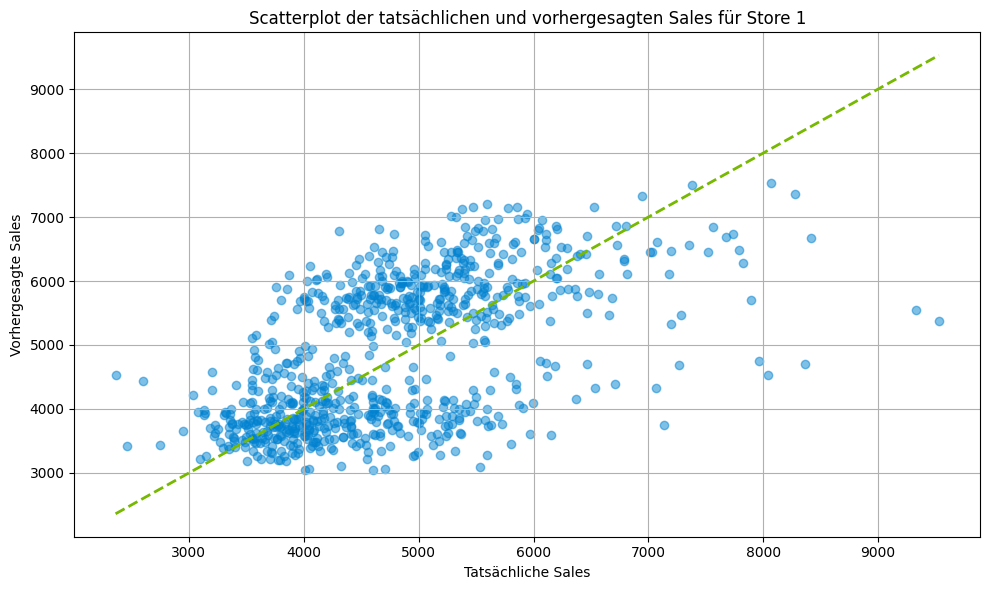

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(y_store, y_store_pred, alpha=0.5, color='#0082D1')
plt.plot([y_store.min(), y_store.max()], [y_store.min(), y_store.max()], '--', lw=2, color='#76B900')
plt.xlabel('Tatsächliche Sales')
plt.ylabel('Vorhergesagte Sales')
plt.title(f'Scatterplot der tatsächlichen und vorhergesagten Sales für Store {store_id}')
plt.grid(True)

plt.tight_layout()
plt.show()

# Quellen

Montesinos López, O.A., Montesinos López, A., Crossa, J. (2022). Support Vector Machines and Support Vector Regression. In: Multivariate Statistical Machine Learning Methods for Genomic Prediction. Springer, Cham. https://doi.org/10.1007/978-3-030-89010-0_9 

OpenAI. (2024). ChatGPT (GPT-4) [Large language model]. https://chat.openai.com/. (Prompt siehe unten)


SciKit-Learn. (n.d.-a). sklearn.pipeline.Pipeline. Scikit-learn. Abgerufen am [22.09.2024], https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

SciKit-Learn. (n.d.-b). sklearn.svm.SVR. Scikit-learn. Abgerufen am [22.09.2024], https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

SciKit-Learn. (n.d.-c). sklearn.svm.LinearSVR. Scikit-learn. Abgerufen am [22.09.2024], https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html

SciKit-Learn. (n.d.-d). sklearn.model_selection.RandomizedSearchCV. Scikit-learn. Abgerufen am [22.09.2024], https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

SciKit-Learn. (n.d.-e). sklearn.model_selection.GridSearchCV. Scikit-learn. Abgerufen am [22.09.2024], https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Muthiah, H., Sa’adah, U., & Efendi, A. (2021). Support vector regression (SVR) model for seasonal time series data. In Proceedings of the Second Asia Pacific International Conference on Industrial Engineering and Operations Management. Surakarta, Indonesia: Brawijaya University.

ChatGPT Prompt:

Frage:

Was sollte ich durchführen GridSearch oder Randomized Search?
linear_svr = LinearSVR()
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_svr)])
linear_pipeline.fit(X_train, y_train)
cv_scores = cross_val_score(linear_pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)
mean_rmspe = np.mean(cv_scores)
y_pred = linear_pipeline.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)

Antwort:

Ob du GridSearchCV oder RandomizedSearchCV verwenden solltest, hängt von mehreren Faktoren ab, insbesondere von der Größe deines Hyperparameterraums und den verfügbaren Rechenressourcen.

1. GridSearchCV
GridSearch durchsucht den gesamten Hyperparameterraum und testet alle möglichen Kombinationen der angegebenen Parameter. Dies führt zu einer exakten Identifikation der besten Hyperparameterkombination, ist aber ressourcenintensiv und skaliert nicht gut mit einer großen Anzahl von Hyperparametern oder vielen Werten für jeden Hyperparameter.

Vorteile:
-Liefert den global optimalen Satz an Hyperparametern innerhalb des angegebenen Suchraums.
- Geeignet, wenn du nur wenige Hyperparameter mit einer überschaubaren Anzahl von Werten hast.

Nachteile:
- Kann sehr langsam sein, besonders bei großen Datensätzen und Modellen mit vielen Hyperparametern.
- Testet auch Kombinationen, die sich als suboptimal herausstellen, was Rechenleistung verschwenden kann.

Wann GridSearch verwenden?
- Wenn du einen kleinen und überschaubaren Hyperparameterraum hast.
- Wenn du genug Rechenleistung und Zeit zur Verfügung hast, um jede Kombination zu testen.

2. RandomizedSearchCV
- RandomizedSearch probiert eine vorgegebene Anzahl an zufälligen Kombinationen aus dem Hyperparameterraum aus. Anstatt alle Kombinationen zu testen, wählt es zufällig eine festgelegte Anzahl von - Konfigurationen, die innerhalb des definierten Bereichs liegen. Dies kann zu einer schnelleren Laufzeit führen, wobei immer noch eine gute Hyperparameterkombination gefunden wird.

Vorteile:
- Erfordert weniger Zeit, da es nur eine Teilmenge der möglichen Hyperparameterkombinationen ausprobiert.
- Skalierbarer bei einem großen Hyperparameterraum oder wenn viele mögliche Kombinationen existieren.
- Auch bei wenigen Iterationen besteht eine hohe Wahrscheinlichkeit, gute Parameter zu finden.

Nachteile:
- Findet nicht immer die optimalen Hyperparameter, sondern nur eine gute Näherung.
- Die Ergebnisse sind zufällig, was bedeutet, dass bei verschiedenen Läufen unterschiedliche Ergebnisse auftreten können.

Wann RandomizedSearch verwenden?
- Wenn der Hyperparameterraum groß oder sehr komplex ist.
- Wenn du schnellere Ergebnisse brauchst oder begrenzte Rechenressourcen hast.
- Wenn du nicht sicher bist, welche Kombinationen der Hyperparameter vielversprechend sind und zunächst einen groben Überblick benötigst.

Empfehlungen für dein Szenario:

Da du Zeitreihen-Kreuzvalidierung mit einem Modell wie LinearSVR verwendest, könnte der Hyperparameterraum relativ groß sein. LinearSVR hat einige wichtige Hyperparameter wie C, epsilon, loss, etc., die du optimieren möchtest.
- Wenn du nur ein paar Hyperparameter (z.B. 2-3) und wenige mögliche Werte (z.B. 3-5) hast, könntest du GridSearchCV verwenden. Das gibt dir eine exakte Lösung für die besten Hyperparameter.
- Wenn du viele Hyperparameter oder einen größeren Bereich an möglichen Werten hast, dann wäre RandomizedSearchCV besser. Du kannst hier eine gewisse Anzahl an Iterationen festlegen (z.B. 50-100) und erreichst schneller eine gute Lösung.

Beispiel für die Anwendung:

GridSearchCV:

from sklearn.model_selection import GridSearchCV

Hyperparameter für LinearSVR
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__epsilon': [0.001, 0.01, 0.1, 1],
    'model__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

GridSearch mit Zeitreihen-Kreuzvalidierung
grid_search = GridSearchCV(linear_pipeline, param_grid, cv=tscv, scoring=rmspe_scorer)
grid_search.fit(X_train, y_train)

Beste Parameter
print("Beste Parameter:", grid_search.best_params_)
RandomizedSearchCV:
python
Code kopieren
from sklearn.model_selection import RandomizedSearchCV

Hyperparameter für RandomizedSearch
param_distributions = {
    'model__C': np.logspace(-3, 3, 10),  # Logarithmische Verteilung der Werte für C
    'model__epsilon': np.logspace(-4, 1, 10),
    'model__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

RandomizedSearch mit 50 zufälligen Kombinationen
random_search = RandomizedSearchCV(linear_pipeline, param_distributions, n_iter=50, cv=tscv, scoring=rmspe_scorer, random_state=42)
random_search.fit(X_train, y_train)

Beste Parameter
print("Beste Parameter:", random_search.best_params_)

Zusammenfassung:
- GridSearchCV ist nützlich bei kleineren Hyperparameterräumen, wo es möglich ist, alle Kombinationen zu testen.
- RandomizedSearchCV ist besser, wenn du viele Hyperparameter oder einen großen Suchraum hast, da es effizienter ist und trotzdem oft gute Ergebnisse liefert.

In den meisten Fällen, besonders wenn du Zeit sparen möchtest, wäre RandomizedSearchCV die bevorzugte Wahl.